In [1]:
# 1. 数据的收集与预处理

## 1.1.  数据收集与可视化分析

In [2]:
import numpy as np 
import pandas as pd 

df_bank = pd.read_csv('/kaggle/input/bank-customer/BankCustomer.csv')
df_bank.head()
# Tenure：已经成为客户的年头。  ProductsNo：拥有的产品数量。
# HasCard：是否有信用卡。      ActiveMember：是否为活跃用户。
# Credit：信用评级。          AccountBal：银行存款余额。        Salary：薪水。

,Name,Gender,Age,City,Tenure,ProductsNo,HasCard,ActiveMember,Credit,AccountBal,Salary,Exited
0,Kan Jian,Male,37,Tianjin,3,2,1,1,634,31937.37,137062,0
1,Xue Baochai,Female,39,Beijing,9,1,1,1,556,18144.95,110194,0
2,Mao Xi,Female,32,Beijing,9,1,1,1,803,10378.09,236311,1
3,Zheng Nengliang,Female,37,Tianjin,0,2,1,1,778,25564.01,129910,1
4,Zhi Fen,Male,55,Tianjin,4,3,1,0,547,3235.61,136976,1


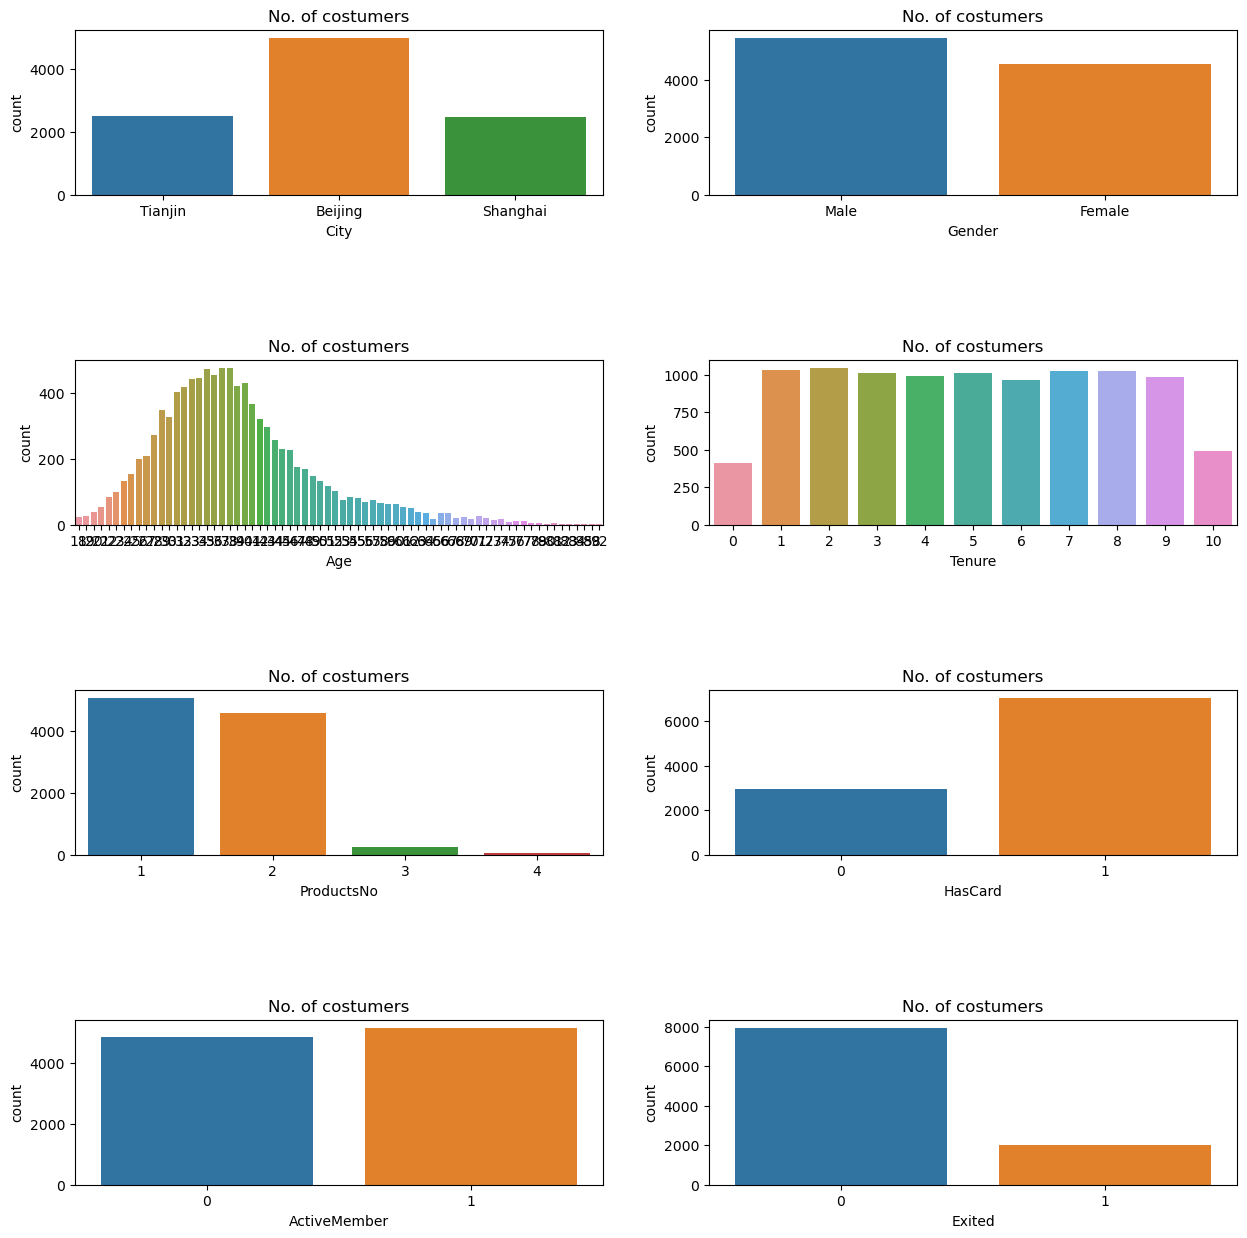

In [3]:
# 显示数据的分布情况：
import matplotlib.pyplot as plt
import seaborn as sns
features = ['City', 'Gender', 'Age', 'Tenure',
                    'ProductsNo', 'HasCard', 'ActiveMember', 'Exited']
fig = plt.subplots(figsize=(15, 15))
for i, j in enumerate(features):
    plt.subplot(4, 2, i + 1)
    plt.subplots_adjust(hspace=1.0)
    sns.countplot(x=j, data=df_bank)
    plt.title("No. of costumers")

从图中大概看得出，北京的客户最多，男女客户比例大概一致，年龄和客户数量呈现正态分布（钟形曲线，中间高两边低）。

对这个数据集，我们主要做以下3方面的清理工作。
1. **性别**。这是一个二元类别特征，需要转换为0/1代码格式进行读取处理（机器学习中的文本格式数据都要转换为数字代码）。
2. **城市**。这是一个多元类别特征，应把它转换为多个二元类别哑变量。
3. **姓名**这个字段对于客户流失与否的预测应该是完全不相关的，可以在进一步处理之前忽略。

## 1.2. 数据集清洗与规范化

In [4]:
# 数据清理：
# 把二元类别文本数字化
df_bank['Gender'].replace("Female", 0, inplace = True)
df_bank['Gender'].replace("Male", 1, inplace = True)
# 显示数字类别
print("Gender unique values: ", df_bank['Gender'].unique())

# 把多元类别转换成多个二元哑变量，然后贴回原始数据集
d_city = pd.get_dummies(df_bank['City'], prefix="City")
df_bank = [df_bank, d_city]
df_bank = pd.concat(df_bank, axis=1)
df_bank.head()

Gender unique values:  [1 0]


,Name,Gender,Age,City,Tenure,ProductsNo,HasCard,ActiveMember,Credit,AccountBal,Salary,Exited,City_Beijing,City_Shanghai,City_Tianjin
0,Kan Jian,1,37,Tianjin,3,2,1,1,634,31937.37,137062,0,0,0,1
1,Xue Baochai,0,39,Beijing,9,1,1,1,556,18144.95,110194,0,1,0,0
2,Mao Xi,0,32,Beijing,9,1,1,1,803,10378.09,236311,1,1,0,0
3,Zheng Nengliang,0,37,Tianjin,0,2,1,1,778,25564.01,129910,1,0,0,1
4,Zhi Fen,1,55,Tianjin,4,3,1,0,547,3235.61,136976,1,0,0,1


## 1.3. 拆分数据集为训练集、测试集、验证集

In [5]:
# 构建特征和标签集合
X = df_bank.drop(['Name', 'Exited', 'City'], axis=1)
y = df_bank['Exited']

# 用标准方法拆分数据集为测试集和训练集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.head()

,Gender,Age,Tenure,ProductsNo,HasCard,ActiveMember,Credit,AccountBal,Salary,City_Beijing,City_Shanghai,City_Tianjin
7389,0,46,2,1,1,1,504,31572.18,201431,0,1,0
9275,1,38,5,2,1,1,684,37926.43,129236,1,0,0
2995,0,39,7,2,0,0,786,19298.20,0,0,1,0
5316,1,37,1,1,1,0,553,5824.38,0,1,0,0
356,1,37,9,1,1,1,469,22923.68,119035,0,1,0


# 2. 构建神经网络(ANN)模型
## 2.1 构建 Sequential ANN 模型

In [6]:
# 1. 用序贯模型构建网络
import keras
from keras.models import Sequential
from keras.layers import Dense

ann = Sequential()
ann.add(Dense(units=12, input_dim=12, activation='relu')) # 添加输入层
ann.add(Dense(units=24,  activation='relu'))    # 添加隐层
ann.add(Dense(units=1, activation='sigmoid'))   # 添加输出层
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                156       
                                                                 
 dense_1 (Dense)             (None, 24)                312       
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 493
Trainable params: 493
Non-trainable params: 0
_________________________________________________________________


## 2.2. 编译网络

In [7]:
# 编译神经网络，指定优化器，损失函数，以及评估标准
ann.compile(optimizer='adam',             # 优化器
            loss = 'binary_crossentropy', # 损失函数
            metrics = ['acc'])            # 评估指标

## 2.3. 训练网络
下面开始训练刚才编译好的神经网络

In [8]:
# 通过history变量把训练过程中的信息保存下来，留待以后分析
history = ann.fit(X_train, y_train,# 指定训练集
                  epochs=30,       # 指定训练轮次
                  batch_size=64,   # 指定数据批量
                  validation_data=(X_test, y_test))   # 指定验证集,这里为了简化模型，直接用测试集数据进行验证

Epoch 1/30
125/125 [==============================] - 4s 5ms/step - loss: 707.9966 - acc: 0.7070 - val_loss: 31.7793 - val_acc: 0.5220
Epoch 2/30
125/125 [==============================] - 0s 3ms/step - loss: 18.4250 - acc: 0.6894 - val_loss: 31.3555 - val_acc: 0.6100
Epoch 3/30
125/125 [==============================] - 0s 3ms/step - loss: 21.7220 - acc: 0.6860 - val_loss: 20.2557 - val_acc: 0.7915
Epoch 4/30
125/125 [==============================] - 0s 3ms/step - loss: 15.7316 - acc: 0.6814 - val_loss: 11.8416 - val_acc: 0.7915
Epoch 5/30
125/125 [==============================] - 0s 3ms/step - loss: 23.3414 - acc: 0.6833 - val_loss: 23.3845 - val_acc: 0.7915
Epoch 6/30
125/125 [==============================] - 0s 3ms/step - loss: 28.1398 - acc: 0.6866 - val_loss: 18.4174 - val_acc: 0.4935
Epoch 7/30
125/125 [==============================] - 0s 3ms/step - loss: 27.6508 - acc: 0.6825 - val_loss: 32.3353 - val_acc: 0.7925
Epoch 8/30
125/125 [==============================] - 0s 3ms/

由上面结果可见，使用顺序ANN网络模型的识别准确率为 71.25%

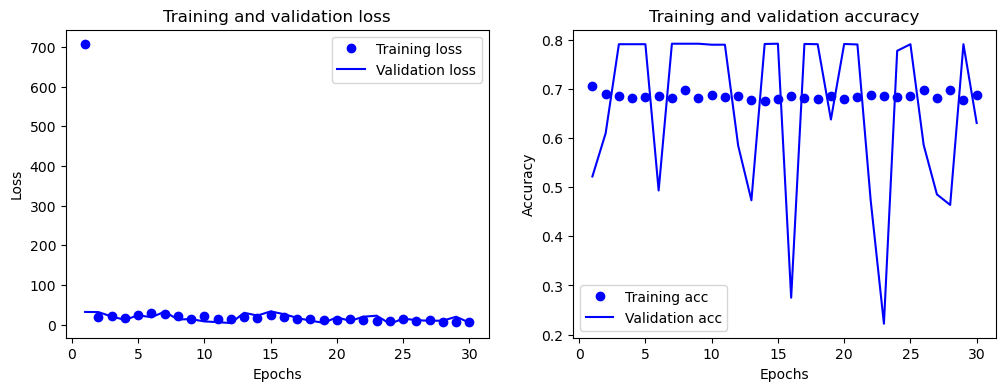

In [9]:
 # 显示训练过程中的学习曲线
 def show_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss)+1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
show_history(history)

# 3 预测与评估模型

## 3.1. 预测测试集标签

In [10]:
y_pred = ann.predict(X_test, batch_size=10) # 预测测试集的标签
y_pred = np.round(y_pred) # 四舍五入，将分类概率值转换成0/1整数值

200/200 [==============================] - 0s 2ms/step


## 3.2. 评估模型结果

使用 `classification_report(y_test, y_pred, labels)` 来评估结果

In [11]:
from sklearn.metrics import classification_report 

def show_report(X_test, y_test, y_pred):
    if y_test.shape != (2000, 1):
        y_test = y_test.values  # 把Panda series转换成Numpy array
        y_test = y_test.reshape(len(y_test), 1) # 转换成与y_pred相同的形状 
    print(classification_report(y_test, y_pred, labels=[0, 1]))

show_report(X_test, y_test, y_pred)

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1583
           1       0.17      0.20      0.18       417

    accuracy                           0.63      2000
   macro avg       0.47      0.47      0.47      2000
weighted avg       0.65      0.63      0.64      2000



结果实在是让人大跌眼镜，神经网络只是简单地把所有的客户判定为该银行忠实的“铁杆”支持者，没有给出任何一例可能离开的客户样本。

因此，尽管准确率达到79%，但对于标签为1的类别而言，精确率、召回率和F1分数居然都为0。

如果此时输出y_pred值，你们会看到清一色的0值。